## Deep Learning Analysis of TCGA Melanoma RNA-Seq Data

### Goal: Distinguish between primary and metastatic samples using:
### 1) WGCNA module eigenvalues
### 2) Cell type frequencies determined by Epic deconvolution
### 3) Epithelial and mesenchymal scores determined by ssGSEA

In [1]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.model_selection import train_test_split 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics


Check GPU for tensorflow use

In [2]:
physical_devices = tf.config.experimental.list_physical_devices("GPU")
print(len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

1


Set pandas option to view all columns

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
os.chdir("/Users/david/Documents/Informatics/TCGA_Melanoma_RNASeq")

Import sample metadata containing primary vs metastatic labels

In [5]:
sample_metadata = pd.read_csv("data/sample_metadata.csv", usecols = ["sample_id", "tumor_descriptor", "tissue_rollup", "ajcc_pathologic_stage"])
#sample_metadata = pd.read_csv("data/sample_metadata.csv")
sample_metadata.head()

,sample_id,tumor_descriptor,ajcc_pathologic_stage,tissue_rollup
0,mel001,Metastatic,Stage IIIC,Lymph_Nodes
1,mel002,Metastatic,Stage III,Cutaneous
2,mel003,Metastatic,Stage I,Lymph_Nodes
3,mel004,Primary,Stage IIC,Cutaneous
4,mel005,Metastatic,Stage IV,Cutaneous


One hot encode metastatic (1) vs. primary (0)

In [6]:
def metastatic_status(row):
    if row["tumor_descriptor"] == "Metastatic":
        val = 1
    else:
        val = 0
    return val

sample_metadata["metastatic"] = sample_metadata.apply(metastatic_status, axis = 1)

sample_metadata.head()

,sample_id,tumor_descriptor,ajcc_pathologic_stage,tissue_rollup,metastatic
0,mel001,Metastatic,Stage IIIC,Lymph_Nodes,1
1,mel002,Metastatic,Stage III,Cutaneous,1
2,mel003,Metastatic,Stage I,Lymph_Nodes,1
3,mel004,Primary,Stage IIC,Cutaneous,0
4,mel005,Metastatic,Stage IV,Cutaneous,1


Import epithelial and mesenchymal scores; only use ssGSEA scores

In [7]:
#epi_mes_score = pd.read_csv("outputs/epi_mes_signature_scores.csv", usecols=lambda x: x != "Unnamed: 0")
epi_mes_score = pd.read_csv("outputs/epi_mes_signature_scores.csv", usecols = ["Sample_ID", "ssGSEA_patient_epi_score", "ssGSEA_patient_mes_score"])
epi_mes_score.head()

,Sample_ID,ssGSEA_patient_epi_score,ssGSEA_patient_mes_score
0,mel001,0.148290,0.600997
1,mel002,0.201204,0.630536
2,mel003,0.157131,0.753071
3,mel004,0.191001,0.554198
4,mel005,0.066584,0.776327


Import WGCNA module eigenvalues

In [8]:
wgcna_module_values = pd.read_csv("outputs/WGCNA_module_eigenvalues.csv")
wgcna_module_values.rename({"Unnamed: 0" : "Sample_ID"}, axis = "columns", inplace = True)
wgcna_module_values.head()

,Sample_ID,MEblue,MEcyan,MEpink,MEturquoise,MEgrey60,MEpurple,MEred,MEyellow,MEmagenta,MEblack,MEmidnightblue,MEgreen,MElightcyan,MEtan,MEgreenyellow,MEbrown,MEsalmon,MEgrey
0,mel354,0.021365,0.048887,-0.041051,0.006600,-0.012043,-0.035691,0.022161,-0.086162,-0.061106,-0.051686,-0.035030,-0.035761,0.016039,0.012688,0.035180,0.023330,-0.001258,-0.045313
1,mel432,0.044640,-0.043526,-0.014845,0.020319,-0.018450,-0.019835,-0.028198,0.057222,-0.000179,-0.024598,-0.048276,-0.062499,-0.053316,-0.030577,-0.011155,-0.024209,0.003056,-0.008772
2,mel243,0.029054,-0.050839,-0.073910,-0.008045,0.028926,0.103280,0.056296,0.045407,0.042255,0.051588,0.013150,0.004086,0.043606,0.008053,-0.016016,-0.023116,0.003431,0.034488
3,mel321,-0.085068,0.022136,0.042147,-0.038917,-0.005708,-0.002704,0.018966,-0.078267,-0.026900,0.024808,0.036798,-0.000306,-0.002811,0.029951,0.057697,0.056513,0.015298,-0.047215
4,mel218,-0.007157,0.032218,0.059814,0.042242,-0.017490,-0.045914,-0.008628,-0.070982,-0.052688,-0.042826,-0.018459,0.044843,0.018809,0.025056,0.018234,0.012279,-0.015445,-0.089578


Import cell type frequencies (deconvolutions)

In [12]:
deconvolutions = pd.read_csv("outputs/deconvolution_epic.csv")
deconvolutions.columns = ["Sample_ID", "Bcells", "CAFs", "CD4_Tcells", "CD8_Tcells", "Endothelial", "Macrophages", "NK_cells", "Other_cells"]
deconvolutions.head()

,Sample_ID,Bcells,CAFs,CD4_Tcells,CD8_Tcells,Endothelial,Macrophages,NK_cells,Other_cells
0,mel354,6.309964e-08,0.023189,1.242557e-08,2.077113e-08,0.109798,0.006240,1.068600e-06,0.860773
1,mel432,5.371025e-02,0.022177,2.651135e-01,1.774601e-01,0.113210,0.015622,3.471369e-10,0.352707
2,mel243,6.987282e-02,0.019708,2.498706e-01,9.722122e-02,0.149929,0.011853,1.552312e-09,0.401546
3,mel321,3.355281e-09,0.025873,5.301670e-02,1.546591e-04,0.178788,0.007887,5.631009e-07,0.734281
4,mel218,4.297526e-10,0.024266,1.502089e-01,2.057413e-07,0.121557,0.011420,4.972481e-06,0.692542


Merge datasets

In [13]:
#could use reduce function
sample_data = pd.merge(epi_mes_score, wgcna_module_values, on = "Sample_ID")
sample_data = pd.merge(sample_data, deconvolutions, on = "Sample_ID")
sample_data.head()


,Sample_ID,ssGSEA_patient_epi_score,ssGSEA_patient_mes_score,MEblue,MEcyan,MEpink,MEturquoise,MEgrey60,MEpurple,MEred,MEyellow,MEmagenta,MEblack,MEmidnightblue,MEgreen,MElightcyan,MEtan,MEgreenyellow,MEbrown,MEsalmon,MEgrey,Bcells,CAFs,CD4_Tcells,CD8_Tcells,Endothelial,Macrophages,NK_cells,Other_cells
0,mel001,0.148290,0.600997,-0.027545,0.000387,0.014077,0.008104,0.008947,-0.005397,-0.019386,0.065154,0.007064,-0.004343,-0.024085,-0.033069,0.050060,0.013841,-0.021276,-0.007611,0.022948,-0.002546,9.968988e-02,0.021295,0.318308,0.149226,0.166616,0.015588,1.107700e-09,0.229278
1,mel002,0.201204,0.630536,-0.033995,0.019817,0.042101,0.011055,-0.018317,-0.022166,-0.032093,0.025428,0.003680,0.013562,0.001150,0.089604,0.015234,-0.018995,0.038869,0.001467,0.001727,-0.038047,4.615041e-02,0.026164,0.224167,0.120172,0.156072,0.014583,2.739297e-10,0.412691
2,mel003,0.157131,0.753071,0.036298,-0.077622,-0.035772,0.020277,0.008077,0.036420,-0.022330,0.107458,0.058522,0.074920,0.012058,0.001457,-0.050802,-0.098055,-0.044914,-0.097102,0.005678,0.007143,8.820742e-02,0.026591,0.387659,0.198735,0.197660,0.014949,1.998165e-11,0.086199
3,mel004,0.191001,0.554198,-0.094353,0.018628,0.032574,-0.053747,0.026845,-0.023554,-0.024285,-0.017145,-0.059329,-0.005891,-0.005694,0.030164,-0.022391,-0.002803,0.080809,0.087251,0.083478,-0.082097,9.173957e-09,0.030979,0.263558,0.024715,0.135000,0.014499,8.735994e-09,0.531249
4,mel005,0.066584,0.776327,0.041007,-0.183339,-0.052832,0.017272,-0.009797,0.036789,-0.019326,0.038650,0.139063,0.134578,0.111221,-0.019151,-0.071603,-0.083565,-0.114759,-0.062507,-0.011321,0.064625,9.130555e-03,0.029362,0.274788,0.082971,0.206039,0.012867,3.083994e-10,0.384843


Get shape: number of samples and features

In [14]:
sample_data.shape


(417, 29)

Check for any missing values

In [15]:
sample_data.isnull().sum()

Sample_ID                   0
ssGSEA_patient_epi_score    0
ssGSEA_patient_mes_score    0
MEblue                      0
MEcyan                      0
MEpink                      0
MEturquoise                 0
MEgrey60                    0
MEpurple                    0
MEred                       0
MEyellow                    0
MEmagenta                   0
MEblack                     0
MEmidnightblue              0
MEgreen                     0
MElightcyan                 0
MEtan                       0
MEgreenyellow               0
MEbrown                     0
MEsalmon                    0
MEgrey                      0
Bcells                      0
CAFs                        0
CD4_Tcells                  0
CD8_Tcells                  0
Endothelial                 0
Macrophages                 0
NK_cells                    0
Other_cells                 0
dtype: int64

Split data into training and test set

In [16]:
x_train, x_test, y_train, y_test = train_test_split(sample_data, sample_metadata, 
                                   random_state = 123,  
                                   test_size = 0.25,  
                                   shuffle = True) 


In [14]:
x_train.head()

,Sample_ID,ssGSEA_patient_epi_score,ssGSEA_patient_mes_score,MEblue,MEturquoise,MEyellow,MEgreen,MEmagenta,MEbrown,MEsalmon,MElightcyan,MEblack,MEgreenyellow,MEred,MEmidnightblue,MEtan,MEcyan,MEpink,MEpurple,MEgrey,Bcells,CAFs,CD4_Tcells,CD8_Tcells,Endothelial,Macrophages,NK_cells,Other_cells
0,mel001,0.149018,0.601737,-0.027554,0.008308,0.065262,-0.011695,0.006539,-0.007475,0.023422,0.008436,-0.020527,0.006892,-0.033263,0.050509,0.011567,0.001519,0.012380,-0.022201,-0.006652,1.006166e-01,0.022282,0.318466,0.148652,0.165866,0.016016,1.873212e-09,0.228101
236,mel265,0.164580,0.646398,-0.007147,0.000953,0.021923,0.032170,-0.012096,0.014447,0.010412,-0.000335,-0.002346,0.012826,-0.015402,-0.016718,0.010495,-0.006281,0.018071,0.034928,-0.058232,5.756868e-02,0.027959,0.243760,0.100826,0.173841,0.013207,9.120124e-10,0.382839
142,mel158,0.171015,0.645084,0.027351,0.035017,0.009240,0.022003,0.043226,-0.041420,0.001017,-0.014389,-0.019244,0.003717,-0.042560,-0.040678,-0.039198,0.081724,-0.013701,-0.120157,0.019335,1.692393e-09,0.026084,0.315195,0.035771,0.164130,0.015531,1.555791e-08,0.443289
341,mel383,0.285390,0.490575,-0.039709,-0.014794,-0.042706,-0.056609,-0.055955,0.063271,0.031900,-0.017027,0.000056,-0.026719,-0.046952,-0.024430,0.017046,0.028117,0.054653,0.059882,-0.053009,2.379470e-09,0.020322,0.162157,0.027555,0.102878,0.011614,3.095212e-09,0.675474
395,mel441,0.391954,0.518266,-0.040127,-0.064210,0.034251,-0.043457,-0.071361,0.072610,0.072112,0.029704,0.122529,0.066335,-0.052110,-0.004422,0.028948,-0.032478,0.031370,0.061320,-0.057223,1.721460e-02,0.019161,0.173689,0.175927,0.105774,0.015172,6.793008e-10,0.493062


In [17]:
x_train.shape


(312, 29)

In [18]:
y_train.shape

(312, 5)

In [19]:
x_test.head()

,Sample_ID,ssGSEA_patient_epi_score,ssGSEA_patient_mes_score,MEblue,MEcyan,MEpink,MEturquoise,MEgrey60,MEpurple,MEred,MEyellow,MEmagenta,MEblack,MEmidnightblue,MEgreen,MElightcyan,MEtan,MEgreenyellow,MEbrown,MEsalmon,MEgrey,Bcells,CAFs,CD4_Tcells,CD8_Tcells,Endothelial,Macrophages,NK_cells,Other_cells
407,mel460,0.211577,0.511322,0.015667,-0.042323,-0.114599,-0.026257,-0.002920,-0.018710,-0.006619,-0.027868,-0.036930,-0.039725,-0.016740,0.026592,0.058227,0.058232,0.026539,0.042498,0.008609,0.012535,6.164373e-03,0.020802,0.128422,6.156450e-02,0.100286,0.013585,2.904184e-11,0.669175
48,mel055,0.469902,0.599975,-0.021614,-0.043056,-0.080242,-0.025945,0.014459,0.114630,0.130935,0.026631,0.037571,0.023663,0.064568,-0.036100,0.023016,0.003942,-0.040957,0.020994,0.063141,0.039534,2.585977e-08,0.017312,0.267110,9.702492e-02,0.147942,0.016151,3.686017e-09,0.454459
310,mel350,0.099315,0.596703,0.045805,-0.016562,-0.018775,0.011082,-0.002704,-0.022183,-0.026862,0.032470,0.003280,0.002545,0.024992,0.000813,-0.039154,-0.027365,-0.009565,-0.020105,-0.000504,-0.015110,5.906630e-02,0.020814,0.224299,9.571182e-02,0.173938,0.016725,1.061215e-10,0.409446
179,mel203,0.207144,0.651773,-0.003758,-0.035839,0.014481,0.034246,-0.018920,-0.004366,-0.018053,-0.046926,0.071495,0.031900,0.035568,-0.007311,0.035791,0.031250,-0.022043,-0.013578,-0.030602,0.060438,5.195362e-03,0.024395,0.200303,1.176717e-07,0.160990,0.010199,4.470034e-11,0.598917
398,mel449,0.181239,0.532887,0.011172,0.013691,0.038558,0.018300,-0.004182,-0.007187,0.023470,-0.075014,0.007743,0.003574,0.034283,-0.015192,0.055773,0.043708,-0.013504,-0.023288,-0.038639,0.010218,6.606863e-09,0.027432,0.054453,1.068026e-08,0.107176,0.006685,8.677064e-07,0.804254


In [20]:
x_test.shape

(105, 29)

In [58]:
x_test.iloc[:, 1:29]



,ssGSEA_patient_epi_score,ssGSEA_patient_mes_score,MEblue,MEcyan,MEpink,MEturquoise,MEgrey60,MEpurple,MEred,MEyellow,MEmagenta,MEblack,MEmidnightblue,MEgreen,MElightcyan,MEtan,MEgreenyellow,MEbrown,MEsalmon,MEgrey,Bcells,CAFs,CD4_Tcells,CD8_Tcells,Endothelial,Macrophages,NK_cells,Other_cells
407,0.211577,0.511322,0.015667,-0.042323,-0.114599,-0.026257,-0.002920,-0.018710,-0.006619,-0.027868,-0.036930,-0.039725,-0.016740,0.026592,0.058227,0.058232,0.026539,0.042498,0.008609,0.012535,6.164373e-03,0.020802,0.128422,6.156450e-02,0.100286,0.013585,2.904184e-11,0.669175
48,0.469902,0.599975,-0.021614,-0.043056,-0.080242,-0.025945,0.014459,0.114630,0.130935,0.026631,0.037571,0.023663,0.064568,-0.036100,0.023016,0.003942,-0.040957,0.020994,0.063141,0.039534,2.585977e-08,0.017312,0.267110,9.702492e-02,0.147942,0.016151,3.686017e-09,0.454459
310,0.099315,0.596703,0.045805,-0.016562,-0.018775,0.011082,-0.002704,-0.022183,-0.026862,0.032470,0.003280,0.002545,0.024992,0.000813,-0.039154,-0.027365,-0.009565,-0.020105,-0.000504,-0.015110,5.906630e-02,0.020814,0.224299,9.571182e-02,0.173938,0.016725,1.061215e-10,0.409446
179,0.207144,0.651773,-0.003758,-0.035839,0.014481,0.034246,-0.018920,-0.004366,-0.018053,-0.046926,0.071495,0.031900,0.035568,-0.007311,0.035791,0.031250,-0.022043,-0.013578,-0.030602,0.060438,5.195362e-03,0.024395,0.200303,1.176717e-07,0.160990,0.010199,4.470034e-11,0.598917
398,0.181239,0.532887,0.011172,0.013691,0.038558,0.018300,-0.004182,-0.007187,0.023470,-0.075014,0.007743,0.003574,0.034283,-0.015192,0.055773,0.043708,-0.013504,-0.023288,-0.038639,0.010218,6.606863e-09,0.027432,0.054453,1.068026e-08,0.107176,0.006685,8.677064e-07,0.804254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,0.187375,0.521134,-0.065922,0.023769,0.054955,0.002889,0.001400,-0.036004,-0.023538,-0.016204,-0.035914,-0.030227,-0.014369,0.026786,0.016280,0.008639,0.057610,0.039894,0.013709,-0.035017,6.019901e-03,0.017584,0.132160,6.804581e-02,0.166535,0.011534,2.127982e-10,0.598121
375,0.173090,0.454862,0.039548,0.039947,-0.011659,-0.004650,0.030987,-0.051467,-0.022693,-0.042402,-0.055286,-0.044442,-0.027511,0.044846,0.058531,0.071193,0.021848,0.028811,-0.023632,-0.011899,2.777005e-09,0.020143,0.088853,3.093932e-02,0.140300,0.010001,3.928666e-05,0.709724
138,0.225781,0.590281,-0.065957,-0.004355,0.050683,-0.046553,0.014800,0.025870,-0.011470,0.059315,-0.018790,0.028602,0.017273,-0.046811,0.014960,0.021663,0.022313,0.030819,0.060348,-0.049491,1.001841e-01,0.020548,0.357468,9.602669e-02,0.186237,0.013065,3.851280e-10,0.226472
151,0.186130,0.527289,0.040309,0.028510,0.044713,0.036899,-0.031522,-0.050904,-0.019869,0.011220,-0.049814,-0.087831,-0.071422,-0.063018,0.010940,-0.005883,0.007055,-0.014145,-0.009376,-0.055073,4.180117e-02,0.013340,0.224505,1.015254e-01,0.099384,0.015129,2.416644e-10,0.504316


Define neural network layers

In [100]:
# define the keras model
model = Sequential()
model.add(Dense(64, input_shape=(28,), activation='relu'))
model.add(Dense(128, activation='relu'))
#model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
#model.add(Dense(2, activation='softmax'))

In [101]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_66 (Dense)            (None, 64)                1856      
                                                                 
 dense_67 (Dense)            (None, 128)               8320      
                                                                 
 dense_68 (Dense)            (None, 1)                 129       
                                                                 
Total params: 10305 (40.25 KB)
Trainable params: 10305 (40.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Define model loss, optimizer and metric functions

In [102]:
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=[keras.metrics.AUC()])
#model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['sparse_categorical_accuracy'])
#model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Fit model to training data; include validation split

In [103]:
# fit the keras model on the dataset
model.fit(x_train.iloc[:,1:29], 
          y_train["metastatic"], 
          validation_split = 0.2,
          epochs = 4000, 
          batch_size = 35, 
          verbose = 2)

Epoch 1/4000
8/8 - 1s - loss: 0.7068 - auc_18: 0.6848 - val_loss: 0.6890 - val_auc_18: 0.7021 - 576ms/epoch - 72ms/step
Epoch 2/4000
8/8 - 0s - loss: 0.6807 - auc_18: 0.6758 - val_loss: 0.6704 - val_auc_18: 0.6847 - 67ms/epoch - 8ms/step
Epoch 3/4000
8/8 - 0s - loss: 0.6630 - auc_18: 0.6340 - val_loss: 0.6525 - val_auc_18: 0.6847 - 63ms/epoch - 8ms/step
Epoch 4/4000
8/8 - 0s - loss: 0.6458 - auc_18: 0.6509 - val_loss: 0.6375 - val_auc_18: 0.6819 - 61ms/epoch - 8ms/step
Epoch 5/4000
8/8 - 0s - loss: 0.6313 - auc_18: 0.6480 - val_loss: 0.6245 - val_auc_18: 0.6778 - 60ms/epoch - 8ms/step
Epoch 6/4000
8/8 - 0s - loss: 0.6189 - auc_18: 0.6278 - val_loss: 0.6148 - val_auc_18: 0.6576 - 61ms/epoch - 8ms/step
Epoch 7/4000
8/8 - 0s - loss: 0.6094 - auc_18: 0.6364 - val_loss: 0.6050 - val_auc_18: 0.6722 - 60ms/epoch - 7ms/step
Epoch 8/4000
8/8 - 0s - loss: 0.5999 - auc_18: 0.6442 - val_loss: 0.5952 - val_auc_18: 0.6764 - 59ms/epoch - 7ms/step
Epoch 9/4000
8/8 - 0s - loss: 0.5905 - auc_18: 0.5991 

Generate predictions on test data

In [105]:
#predict on test data
predictions = model.predict(x_test.iloc[:,1:29])
print(predictions)

4/4 [==============================] - 1s 167ms/step
[[1.4604765e-01]
 [1.9986693e-02]
 [9.0970874e-01]
 [9.4403857e-01]
 [3.5853261e-01]
 [7.2706980e-01]
 [9.9596775e-01]
 [1.5849149e-01]
 [9.4689800e-05]
 [9.7998571e-01]
 [7.2904956e-01]
 [7.3776615e-01]
 [1.4588064e-01]
 [2.2840481e-02]
 [6.1573392e-01]
 [7.7579278e-01]
 [9.6271968e-01]
 [7.1889305e-01]
 [3.0085084e-01]
 [5.5327928e-01]
 [2.7964935e-02]
 [9.9437654e-01]
 [7.7559161e-01]
 [3.6557072e-01]
 [8.5237175e-01]
 [8.7222958e-01]
 [6.9460326e-01]
 [5.0634456e-01]
 [9.7183901e-01]
 [9.8632312e-01]
 [6.8328792e-01]
 [7.9171950e-01]
 [9.1758448e-01]
 [8.1990772e-01]
 [7.4978173e-01]
 [4.3894667e-02]
 [8.5867673e-01]
 [9.5236617e-01]
 [2.4122430e-01]
 [8.4650183e-01]
 [9.4490790e-01]
 [8.8559818e-01]
 [9.2490572e-01]
 [6.1496741e-01]
 [5.4969132e-01]
 [3.5114589e-01]
 [6.0310268e-01]
 [5.7410151e-01]
 [4.9589429e-02]
 [9.0926600e-01]
 [9.8882675e-01]
 [1.3526893e-01]
 [2.7354315e-01]
 [6.4797211e-01]
 [6.7341751e-01]
 [5.6228054e

Make model predictions into a dataframe

In [106]:
predictions = pd.DataFrame(predictions,
                           columns = ["Model_Value"])
predictions.head()

,Model_Value
0,0.146048
1,0.019987
2,0.909709
3,0.944039
4,0.358533


Round predictions into 0 (primary) and 1 (metastatic) values

In [107]:
predictions["Prediction"] = predictions.iloc[:,0].round(0)
predictions.head()

,Model_Value,Prediction
0,0.146048,0.0
1,0.019987,0.0
2,0.909709,1.0
3,0.944039,1.0
4,0.358533,0.0


Generate a confusion matrix

In [108]:
conf_maxtrix = confusion_matrix(y_true = y_test["metastatic"],
                                y_pred = predictions["Prediction"])
print(conf_maxtrix)

[[17  6]
 [16 66]]


Plot confusion matrix

[Text(0, 0.5, 'Primary'), Text(0, 1.5, 'Metastatic')]

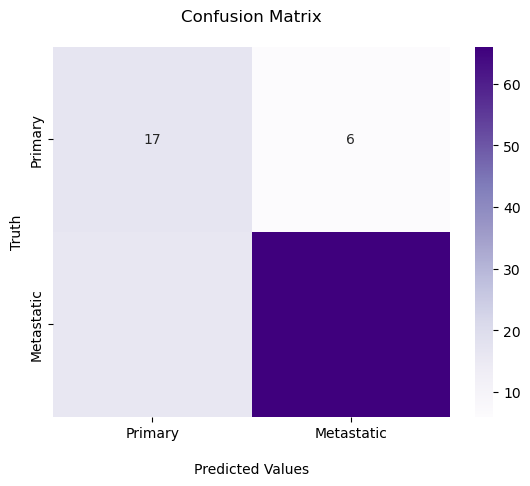

In [109]:
ax = sns.heatmap(conf_maxtrix, annot = True, cmap = 'Purples')

ax.set_title('Confusion Matrix\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Truth');

ax.xaxis.set_ticklabels(['Primary','Metastatic'])
ax.yaxis.set_ticklabels(['Primary','Metastatic'])

#bottom annotations are missing?


Plot confusion matrix a different way

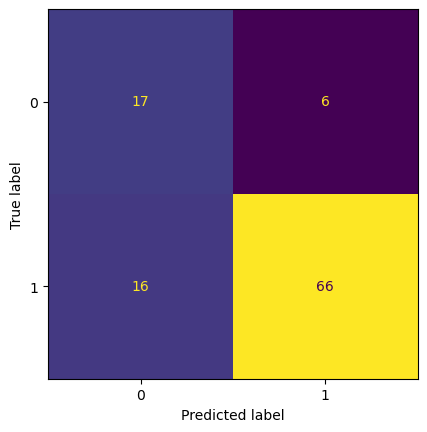

In [110]:
ConfusionMatrixDisplay.from_predictions(y_test["metastatic"], 
                                        predictions["Prediction"],
                                        colorbar = False)

Make a function for generating a line with slop 1 to use in the ROC plot

In [111]:
def abline(slope, intercept):
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

ROC AUC plot

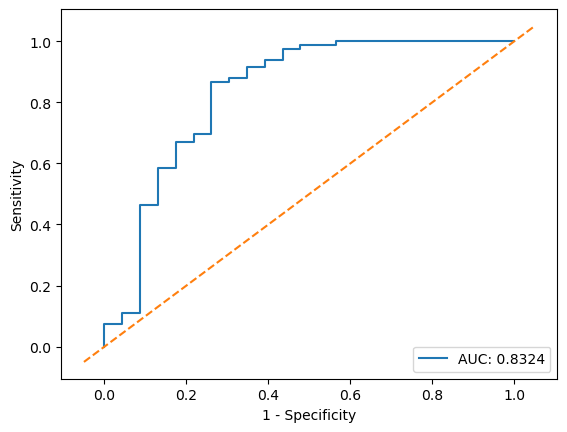

In [112]:
fpr, tpr, _ = metrics.roc_curve(y_test["metastatic"], 
                                predictions.iloc[:,0])

auc = metrics.roc_auc_score(y_test["metastatic"], 
                                predictions.iloc[:,0])

plt.plot(fpr, tpr, label = "AUC: "+str(auc.round(4)))
abline(1,0)
plt.xlabel("1 - Specificity")
plt.ylabel("Sensitivity")
plt.legend(loc = 4)
plt.show()